<a href="https://colab.research.google.com/github/tozanni/COVID19_MEX_MASTER/blob/master/COVID_Ajuste_de_parametros_con_PyMC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ajuste de parámetros del modelo SEIR (Versión probabilística)

Eduardo H. Ramirez (eduardo@ensitech.com)

Basado en la implementación de SEIR de de Miguel Núñez publicada en:

https://github.com/NunezKant/COVID-19_GDL/blob/master/Desarrollo_de_COVID_19_en_Guadalajara_Miguel_N%C3%BA%C3%B1ez.ipynb

Se basa también en el siguiente trabajo de ajuste de parámetros por mínimos cuadrados (Eduardo Ramirez)

https://colab.research.google.com/drive/1mhRUkpmttCNgTPq6DYs6xn1tF3V82q45

**Referencia PyMC3**

https://docs.pymc.io/notebooks/ODE_API_introduction.html

OJO: Requiere actualizar a PyMC 3.8


In [0]:
%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

In [0]:
# El modulo ode viene en 3.8
# !pip install pymc3==3.8

In [0]:
"""
def SEIR(y, t, p):
  alpha,beta,gamma = p
  S, E, I, R = y
  ds = -beta*S*I
  de = beta*S*I - alpha*E
  di = alpha*E - gamma*I
  dr = gamma*I
  return [ds, de, di, dr]

alpha = p[0]
beta = p[1]
gamma = p[2]

S = y[0]
E = y[1]
I = y[2]

"""
## Sintaxis PyMC3 

def SEIR(y, t, p):
    ds = -p[1]*y[0]*y[2]
    de = p[1]*y[0]*y[2] - p[0]*y[1]
    di = p[0]*y[1] - p[2]*y[2]
    dr = p[2]*y[2]
    return [ds, de, di, dr]


In [0]:
np.random.seed(42)

alpha = 0.2
beta = 1.75
gamma = 0.5
#theta = 1.0

#params = alpha, beta, gamma
times = np.arange(0,90,1) # 90 dias
#times

## Condiciones iniciales (porcentuales)
Pop = 4225000  # ZMM
I_o = 32 / Pop  # Tenemos 32 casos
E_o = (32*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

## Curva de modelo
y = odeint(SEIR,t=times,y0=[S_o,E_o,I_o,R_o], args=((alpha, beta, gamma),), rtol=1e-08)

## Curva de observaciones
#22 de Marzo: 32
#23 de Marzo: 48
#24 de Marzo: 52
#25 de Marzo: 57
#26 de Marzo: 60

yobs = np.array([ 32, 48, 52, 57, 60 ])
#yobs_norm = yobs / Pop
#print([S_o,E_o,I_o,R_o]*Pop)

In [0]:
y[:5,2]*Pop

array([32.        , 42.49055202, 55.49879579, 72.14815185, 93.65416367])

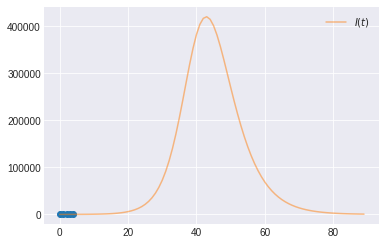

In [0]:
plt.plot(yobs, marker='o', linestyle='none')
plt.plot(times, y[:,2]*Pop, color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

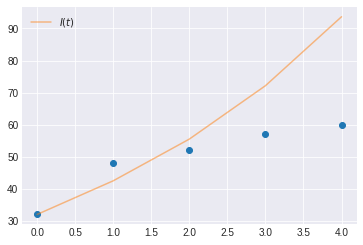

In [0]:
## Primeras 5 observaciones
plt.plot(yobs, marker='o', linestyle='none')
#plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(y[:5,2]*Pop, color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [0]:
yobs = np.random.normal(y,2)
#yobs.shape
yobs.shape

(90, 4)

In [0]:
# Observaciones (I)
# [ 32, 48, 52, 57, 60 ]

Pop = 4225000  # ZMM
I_o = 32 / Pop  # Tenemos 32 casos
E_o = (32*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

def SEIR_Day(i,r):
  """ 
  Produce los datos normalizados de S,E,I,R dados I y R del dia.
  """
  I = i / Pop
  E = (i*4) / Pop # Ojo aca con el 4
  S = 1 - (E*I)
  R = r / Pop
  return [S, E, I, R]

yobs = np.array([
    SEIR_Day(32,0),
    SEIR_Day(48,0),
    SEIR_Day(52,0),
    SEIR_Day(57,0),
    SEIR_Day(60,0)
  ]
)


In [0]:
obs_times=np.arange(0,yobs.shape[0],1)
obs_times

array([0, 1, 2, 3, 4])

In [0]:
## Times equiparar al yobs
seir_model = DifferentialEquation(
    func=SEIR,
    times=obs_times,
    n_states=4,
    n_theta=3,
)

In [0]:

with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 0.25)
    
    p_alpha = pm.Bound(pm.Normal, lower=0, upper=1)("alpha",0.2,0.1)  # Inverso, entre cero y uno
    p_gamma = pm.Bound(pm.Normal, lower=0, upper=1)("gamma",0.5,0.25)  # Tasa, entre cero y uno
    R0 = pm.Bound(pm.Normal, lower=1, upper=4)('R0', 2,3)
    p_beta = pm.Deterministic('beta', p_gamma*R0)

    seir_curves = seir_model(y0=[S_o,E_o,I_o,R_o], theta=[p_alpha, p_beta, p_gamma])
    Y = pm.Normal('Y', mu=seir_curves, sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000,tune=1000, target_accept=0.9, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R0, gamma, alpha, sigma]
100%|██████████| 4000/4000 [01:33<00:00, 42.71it/s]


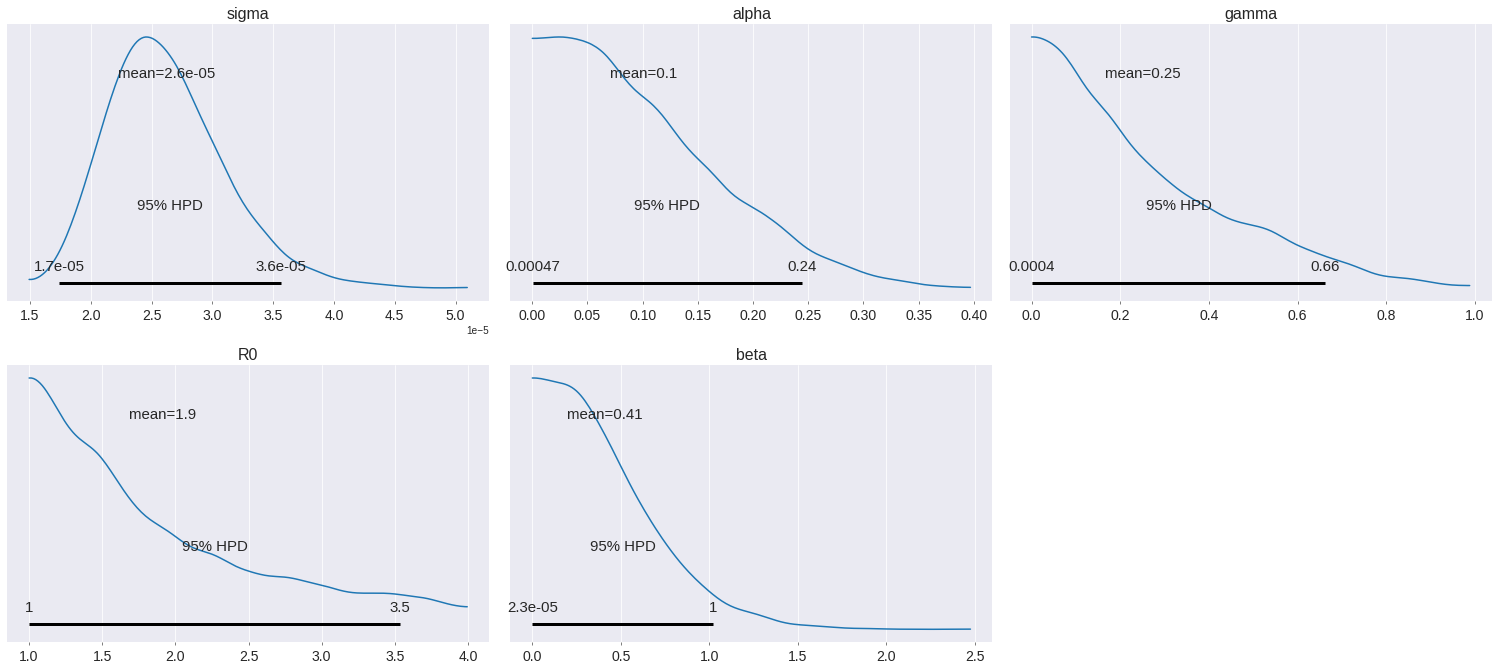

In [0]:
az.plot_posterior(data,round_to=2, credible_interval=0.95);


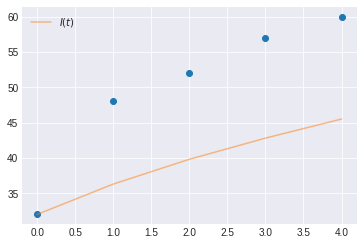

In [0]:
## Curva de modelo con parametros fiteados

times = np.arange(0,180,1) # 90 dias

## Condiciones iniciales (porcentuales)
Pop = 4225000  # ZMM
I_o = 32 / Pop  # Tenemos 32 casos
E_o = (32*4) / Pop # Asumimos 4 expuestos por caso
S_o = 1 - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

## Curva de modelo vs. observaciones
y = odeint(SEIR,t=times,y0=[S_o,E_o,I_o,R_o], args=((0.1, 0.41, 0.25),), rtol=1e-08)

yobs = np.array([ 32, 48, 52, 57, 60 ])

## Fit de primeras 5 observaciones
plt.plot(yobs, marker='o', linestyle='none')
#plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(y[:5,2]*Pop, color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

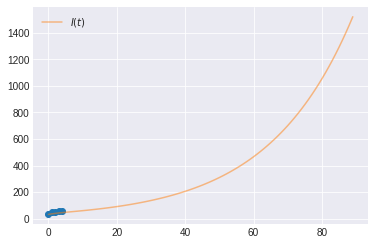

In [0]:
plt.plot(yobs, marker='o', linestyle='none')
plt.plot(times, y[:,2]*Pop, color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()